## Problem Statement

Currently a lot of travel accomodation services has their own filters when recommending places to stay.
However, these searches are based on the physical traits of the property or rental.
When users do searches on airbnb/hotels in certain areas, they would need to filter by area and read the comments of the place/organisation individually. This usually takes up a lot of time!

Hence, another way that can change this experience is to:
Allows searches based on experiences / user reviews (especially local attractions; Chinatown, LittleIndia, etc..)
Thus, users will be able to read up and search for reviews and location at the same time.

**The idea is to build a Named Entity Recognition (NER) model using deep learning, and then compare it to existing pre-trained model to analyse their efficiency, as in how well these models can learn the local areas in Singapore.**

## Executive Summary

*  
*  
*  
*  
*  
*  
*  
*  

## Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# Imports for pre-processing and EDA
import regex as re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
# Imports for spacy retraining
from tqdm import tqdm
import spacy
from spacy.tokens import DocBin

# Import gcld3 for language detection
import gcld3

# Import google trans module
from google_trans_new import google_translator

In [4]:
# Show max columns and rows
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Display max
pd.set_option('display.max_colwidth', None)

## Load Data / Data Cleaning

In [5]:
# Load review.csv
review = pd.read_csv('../data/reviews.csv')

In [6]:
# Check reviews
review.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,49091,8243238,2013-10-21,8557223,Jared,Fran was absolutely gracious and welcoming. Made my stay a great experience. Would definitely recommend this cozy and peaceful place to anyone.
1,50646,11909864,2014-04-18,1356099,James,A comfortable room in a smart condo development. Everything was kept very clean and I had the use of my own bathroom. Sujatha and her husband are great hosts - very friendly and accommodating. I'll be staying here again.
2,50646,13823948,2014-06-05,15222393,Welli,"Stayed over at Sujatha's house for 3 good nights with my boyfriend. Sujatha and her husband are great hosts, very welcoming and friendly. The room is comfortable and clean. I'm happy to have my own bathroom as i'm particular with shared bathroom. \r\nThe location is accessible. A few minutes walk from the house to nearest bus stop which can bring you to town.\r\nGood place, good hosts, good price.\r\nHighly recommended!"
3,50646,15117222,2014-07-02,5543172,Cyril,It's been a lovely stay at Sujatha's. The room is clean and the location is just perfect for a stop-over in Singapore. I really enjoyed relaxing at the swimming pool after spending most of the day in the city. Thank you Sujatha.
4,50646,15426462,2014-07-08,817532,Jake,"We had a great experience. A nice place, an amazing complex and easy access to public transit"


In [7]:
# Check data types of columns
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53325 entries, 0 to 53324
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     53325 non-null  int64 
 1   id             53325 non-null  int64 
 2   date           53325 non-null  object
 3   reviewer_id    53325 non-null  int64 
 4   reviewer_name  53325 non-null  object
 5   comments       53232 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.4+ MB


In [8]:
# Check if df contains NA
review.isnull().sum().sort_values(ascending=False)

comments         93
listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
dtype: int64

A total of 93 people provided reviews but didnt input any comments.
We will drop them out instead.

In [9]:
# Drop NA
review.dropna(inplace=True)

In [10]:
# Check NA count
review.isnull().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

Create a 'length' of words in comments column

In [11]:
# Create a 'length' column - length of review words
review['length'] = review['comments'].map(lambda x: len(x.split()))

Use gcld3 package to detect the language of comments

In [13]:
# Instantiate gcld3 identifier
detector = gcld3.NNetLanguageIdentifier(min_num_bytes=0, 
                                        max_num_bytes=1000)

In [14]:
# Run gcld3 identifier through all reviews and append into 'language' column

lang_list = []
for sentence in review['comments']:
    try:
        result = detector.FindLanguage(text=sentence)
        lang_list.append(result.language)
    except:
        det = 'No words'
        lang_list.append(det)
        continue
review['language'] = lang_list

In [15]:
# Check df
review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,length,language
0,49091,8243238,2013-10-21,8557223,Jared,Fran was absolutely gracious and welcoming. Made my stay a great experience. Would definitely recommend this cozy and peaceful place to anyone.,22,en
1,50646,11909864,2014-04-18,1356099,James,A comfortable room in a smart condo development. Everything was kept very clean and I had the use of my own bathroom. Sujatha and her husband are great hosts - very friendly and accommodating. I'll be staying here again.,39,en
2,50646,13823948,2014-06-05,15222393,Welli,"Stayed over at Sujatha's house for 3 good nights with my boyfriend. Sujatha and her husband are great hosts, very welcoming and friendly. The room is comfortable and clean. I'm happy to have my own bathroom as i'm particular with shared bathroom. \r\nThe location is accessible. A few minutes walk from the house to nearest bus stop which can bring you to town.\r\nGood place, good hosts, good price.\r\nHighly recommended!",71,en
3,50646,15117222,2014-07-02,5543172,Cyril,It's been a lovely stay at Sujatha's. The room is clean and the location is just perfect for a stop-over in Singapore. I really enjoyed relaxing at the swimming pool after spending most of the day in the city. Thank you Sujatha.,42,en
4,50646,15426462,2014-07-08,817532,Jake,"We had a great experience. A nice place, an amazing complex and easy access to public transit",17,en


In [16]:
# Check value counts of languages
review['language'].value_counts().head(20)

en    43533
zh     4194
ko      736
ja      728
fr      611
de      494
uk      311
lt      302
es      214
ru      171
sr      140
mr      127
hi      120
no      118
it       89
nl       76
tg       72
la       70
fy       69
ne       69
Name: language, dtype: int64

Most languages are written in English, followed by Chinese. Followed by Korean, Japanese, French and German.

In [17]:
review[review['language']=='ja']['comments']

74                                                                              弾丸旅行のため､深夜に到着し､深夜に出発した我々を暖かく迎えてくれ､また送り出してくれました｡短期滞在で他の宿泊者との交流ができなかったのが残念です｡お世話になりました｡
365                                                                                                                                                     Good location
375      駅から歩いてすぐです｡駅前にはﾓｰﾙもたくさんあるし､空港までのｱｸｾｽも抜群です｡部屋はﾘﾋﾞﾝｸﾞに赤いｿﾌｧがあったりと､男友達の家に泊めてもらったような感じです｡ｵｰﾅｰのﾗｳﾙ氏も素敵な方です｡ﾁｪｯｸｱｳﾄ後も部屋に荷物を置かせていただき､ｺｲﾝﾛｯｶｰが少ないので夜のﾌﾗｲﾄまで大変助かりました｡
382                                                                    立地はとてもいいです｡\n布団のｼｰﾂなどは､洗っているのかが不明な匂いだったので､もっていた布類で覆って寝ました｡ｷｯﾁﾝはｵｰﾅｰの使用済みの食器などがおいてあり､清潔とはいえません｡
485                      在这里住了7天,干净,卫生,安静｡房东非常友好,中文沟通无障碍,强烈推荐!\nStayed here for 7 days, clean, hygienic and quiet. The landlord is very friendly. Highly recommended!
                                                                                     ...                                                                             
5324

There are quite some reviews misclassified with the wrong languages:

- english (en) as japanese (ja) as shown above

This problem is inherent with other language detector packages as well. Main reason is because of the short length of sentences or mixed languages present inside any review.

In order to get a consistent review, we will remove comments that are less than 10 words, except for chinese written reviews. This is because in chinese, sentences are written continuously without whitespace, which will only get recognized as length of '1'.

We only want reviews that are more than 10 words because a good review should include enough detail to give others a feel for what happened or was experienced. 

In [18]:
# Example of reviews given in Chinese (length == 1)
review[(review['length']<10) & (review['language']=='zh')].head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,length,language
47,71609,49743263,2015-10-05,45520800,俊銘,"預定兩間房六人入住兩天~一間房間有雙人床及單人床,另一間卻是雙人床和一壞掉床架在用釘上木板,兩間共用一個衛浴設備,跟房東反應卻推給菲傭說她搞不清楚狀況,明顯得再推卸責任,第二天一大早便退房不願意再繼續住宿,真是讓人失望.",1,zh
52,71609,506771460,2019-08-11,175659770,Chun Yan,"出行方便,房东人非常好｡也很热情｡是个不错的选择",1,zh
75,71896,42917808,2015-08-16,38113704,Xiaohui,"房间和描述的一样的,离机场很近,坐9路两站就到地铁,还满方便的｡这个房间与2号是共用卫生间的,清洁度不错,早餐是鸡蛋炒米粉,稍简单了些｡",1,zh
96,71903,42912798,2015-08-16,38113704,Xiaohui,"房间和描述的一样的,离机场很近,坐9路两站就到地铁,还满方便的｡这个房间与3号是共用卫生间的,清洁度不错,早餐是鸡蛋炒米粉,稍简单了些｡",1,zh
97,71903,45702083,2015-09-05,41241807,Jian,"房子坐落于simmei(四美)的排屋区｡房子很安静,房间整齐｡居住下来才知道房东太太是出租车司机,这一点大大的方便了前往机场的我们!居住很愉快,但也有两点遗憾:1､屋子不好找,若以后能配上地图就更好了;2､有蚊子｡",1,zh


In [19]:
# tbd = to-be-dropped
# Create a list of indexes of which length is less than 10 and not Chinese then drop them

tbd = list(review[(review['length']<10) & (review['language']!='zh')].index)
review = review.drop(tbd)

Next, is to translate the non-english comments into english to be processed the NER recognition model.

For this task, we will use the GoogleTranslator API to perform translation.

In [20]:
# Simple function to translate text to EN

def trans(df):
#    try:
    if df['language'] != 'en':
        translator = google_translator(url_suffix='sg', proxies=None)
        translate_text = translator.translate(df['comments'],lang_tgt='en')
        print(translate_text)
        time.sleep(2)
        return translate_text
    else:
        print(df['comments'])
        return df['comments']
#    except:
#        print('fail')

==============================================================================================  
BELOW CODE IS COMMENTED OUT, BECAUSE IT WILL TAKE A FEW HOURS TO COMPLETE THE TRANSLATION DUE   
API LIMIT PER HOUR. LIMIT IS AT 5000 PER HOUR.

review['re_comments'] = review.apply(trans, axis=1)

==============================================================================================

In [21]:
# Since we skipped above code, we will just call out the saved csv
review = pd.read_csv('../data/cleaned_review.csv')
review = review.drop(columns=['nltk','spacy','spacy_retrain','lstm'])

In [22]:
# Check the first few converted reviews using GoogleTranslator
review[review['language']!='en'].head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,length,language,re_comments
15,50646,21279532,2014-10-14,18046573,Cora,"Wir hatten ein paar tolle Tage bei Sujatha. Sie ist eine freundliche und nette Person, die stehts ihre Hilfe angeboten hat. Ihre Kinder sind ebenfalls nette und hiflsbereite Menschen. Die Unterkunft war im großen und ganzen sauber und schön. Insbesondere die große Poolanlage mit 25 Meter Bahn lädt zum Schwimmen ein. Vielen Dank für die schöne Zeit! Gruß Cora und Annika.",61,de,We had a few great days at Sujatha. She is a friendly and nice person who has offered your help stands. Her children are also nice and hi-lins-ready people. The accommodation was on the whole clean and beautiful. Especially the large pool area with 25 meters of train invites you to swim. Thank you for the wonderful time! Greeting Cora and Annika.
44,71609,49743263,2015-10-05,45520800,俊銘,"預定兩間房六人入住兩天~一間房間有雙人床及單人床,另一間卻是雙人床和一壞掉床架在用釘上木板,兩間共用一個衛浴設備,跟房東反應卻推給菲傭說她搞不清楚狀況,明顯得再推卸責任,第二天一大早便退房不願意再繼續住宿,真是讓人失望.",1,zh,"Book two rooms and six people stay for two days ~ one room has double beds and single beds, and the other is double bed and a broken bed frame in the wooden board with nail, two bathrooms, and the landlord response However, it is pushed to the Philippine Aviator, she is unclear, and she is obvious to shirk responsibility. After the next morning, she is not willing to continue to stay again, it is really disappointing."
47,71609,506771460,2019-08-11,175659770,Chun Yan,"出行方便,房东人非常好｡也很热情｡是个不错的选择",1,zh,"It is convenient to travel, the landlord is very good. It is also very enthusiastic. It is a good choice."
67,71896,42917808,2015-08-16,38113704,Xiaohui,"房间和描述的一样的,离机场很近,坐9路两站就到地铁,还满方便的｡这个房间与2号是共用卫生间的,清洁度不错,早餐是鸡蛋炒米粉,稍简单了些｡",1,zh,"The rooms are the same, close to the airport, sitting on the 9-way station to go to the subway, is still convenient. This room and the No. 2 are shared toilet, the cleanliness is good, the breakfast is the egg fried rice noodles, slightly simple ."
87,71903,42912798,2015-08-16,38113704,Xiaohui,"房间和描述的一样的,离机场很近,坐9路两站就到地铁,还满方便的｡这个房间与3号是共用卫生间的,清洁度不错,早餐是鸡蛋炒米粉,稍简单了些｡",1,zh,"The rooms are the same, close to the airport, sitting on the 9-way station to go to the subway, is still convenient. This room is shared with the 3rd, the cleanliness is good, the breakfast is a fried rice noodle, slightly simple ."


Overall, the translated reviews are quite good and readable. However, we do see some context lost, as noticed by the review translated from German (de). 

---> 'Her children are also nice and hi-lins-ready people' 
There is no such word for 'hilins-ready'

The translator is not perfect, but for this task, we will deem is as more than enough.

## EDA

In [23]:
# Dictionary of English contractions
# Expand the words in reviews

contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Replace contractions with full words
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

In [24]:
# Pre-process the reviews so that we can analyse the words

def review_to_words(raw_review):
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    
    # 2. Remove word contractions
    review_text = expand_contractions(review_text)
    
    # 3 Remove HTTPS://
    review_text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',review_text)
    
    # 4. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 5. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 6. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
    # 7. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 8. Lemmatize each word
    lemmatizer = WordNetLemmatizer()
    meaningful_words = [lemmatizer.lemmatize(w) for w in meaningful_words]  #Noun
    meaningful_words = [lemmatizer.lemmatize(w, wordnet.VERB) for w in meaningful_words]  #Verb
    meaningful_words = [lemmatizer.lemmatize(w, wordnet.ADJ) for w in meaningful_words]  #Adjective
    meaningful_words = [lemmatizer.lemmatize(w, wordnet.ADV) for w in meaningful_words]  #Adverb
    
    # 9. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [25]:
# Run function to remove stopwords, lemmatize, etc.
features = [review_to_words(s) for s in review['re_comments']]

In [26]:
# Check processed review [0]
features[0]

'fran absolutely gracious welcome make stay great experience would definitely recommend cozy peaceful place anyone'

In [27]:
# Check processed review [1000]
features[1000]

'paul provide incorrect date availability put spot last minute even will accommodate request stay even though advertise bad experience avoid'

In [28]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()

# Fit the vectorizer on our corpus.
cvec.fit(features)

# Transform the corpus.
features_cvec = cvec.transform(features)

# Convert into DF
lf_df = pd.DataFrame(features_cvec.toarray(), columns=cvec.get_feature_names())

In [29]:
# Create a list of top30 single words
list1 = lf_df.sum().sort_values(ascending=False).head(30)

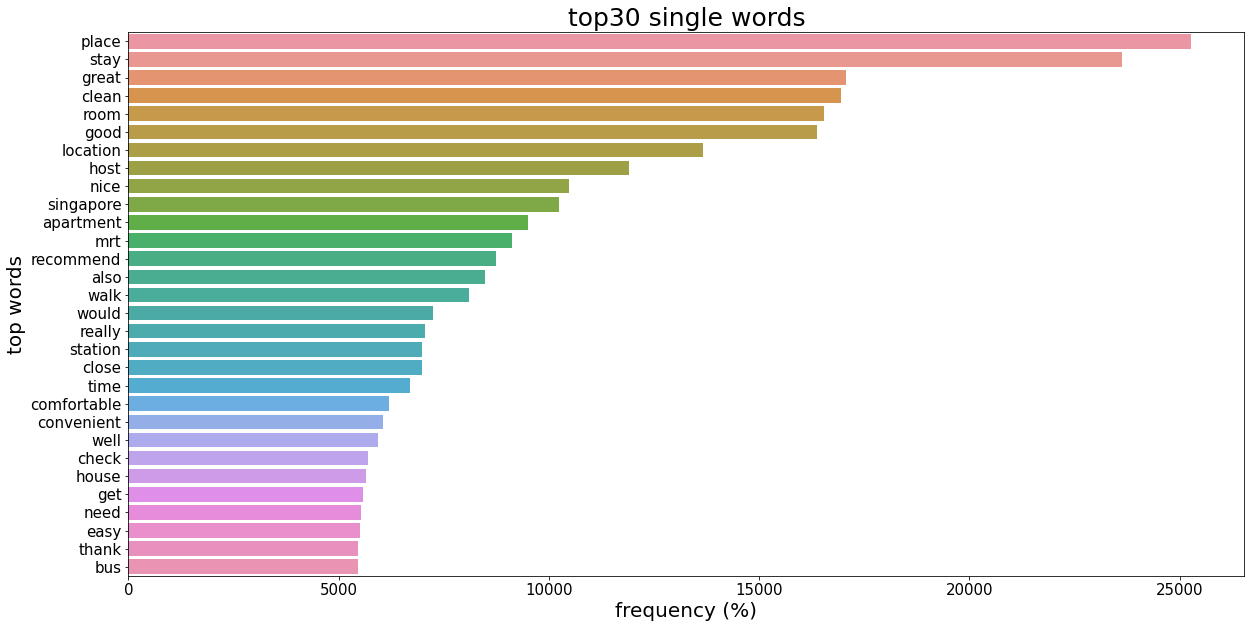

In [30]:
# Plot the top30 single words
plt.figure(figsize=(20,10))
plt.title('top30 single words',fontsize=25)
plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('top words',fontsize=20)
plt.tick_params(labelsize=15)

sns.barplot(x=list1.values,y=list1.index);

**Only 1 location entity ('singapore') in our top words!**

In [31]:
# Check for top words
# Check for n-gram 

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:30]

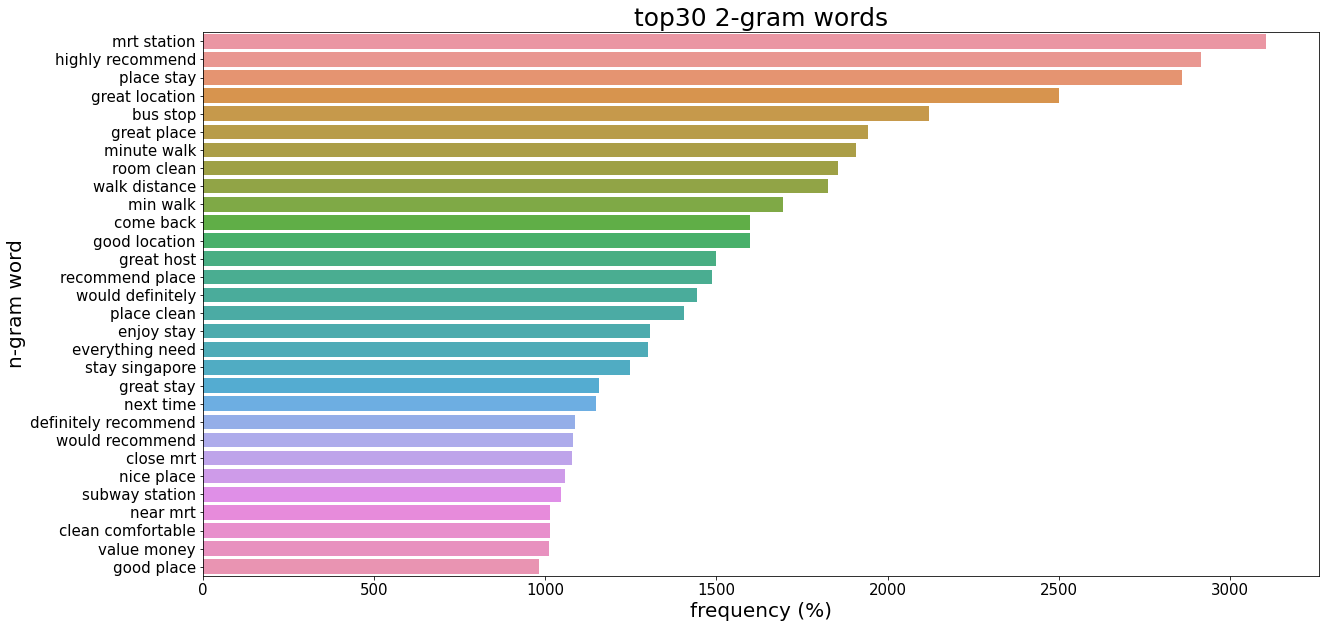

In [32]:
# Plot the top30 2-gram words in reviews
plt.figure(figsize=(20,10))
plt.title('top30 2-gram words',fontsize=25)
plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('n-gram word',fontsize=20)
plt.tick_params(labelsize=15)

top_tri_grams=get_top_ngram(features,n=2)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x);

Do not see any words that are of our interest. Example - (Tiong Bahru, Orchard Road, Sentosa Beach..)

## Named Entity Recognition

Before we start running models, we need a way to compare between models.

To see how well the models perform, we will create a list of local places that we can use to compare the performances from each model. ie; How many can each model recognize out of the views.

In [33]:
# List of local attractions

# Based on https://en.wikipedia.org/wiki/List_of_tourist_attractions_in_Singapore
# and https://www.stb.gov.sg/content/stb/en/home-pages/approved-attractions.html

local_list = ['Marina Bay Sands','East Coast Park','Boat Quay','Clarke Quay',
              'Arab Street','Little India','Bugis Junction','Tanjong Pagar','Tiong Bahru',
              'Farrer Park','Holland Village','Jalan Besar']

In [34]:
# Create a df - count of entities recognized
count = pd.DataFrame()
count['place'] = local_list

# Sweep through the review csv if review contains interested place
count['count'] = [len(review[review['re_comments'].str.contains(local)]) for local in local_list]

We will refrain from using certain words such as 'Chinatown' or 'Orchard' because it is quite difficult to ascertain accurately if the review contains 'Chinatown' or 'Chinatown Point' or 'Chinatown Complex'.   
Hence, we picked words that will most probably not have an extension to the words.

### NLTK

Identify named entities (NE) using NLTK model.  
Natural Language Toolkit [NLTK](https://www.nltk.org) is a leading platform for building Python programs to work with human language data. 

In [35]:
# Simple function to use NLTK model to extract entities
def nltk_ne(text):

    entities = []

    sentence = nltk.sent_tokenize(text)
    for sent in sentence:
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent)), binary=False):
            if hasattr(chunk, 'label'):
                entities.append(' '.join(c[0] for c in chunk))

    entities_labels = list(set(entities))
    return entities_labels

In [36]:
# Run the function through comments column and add entities to 'nltk' column in csv file
review['nltk'] = [nltk_ne(review) for review in review['re_comments']]

In [38]:
# Check df
review.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,length,language,re_comments,nltk
0,49091,8243238,2013-10-21,8557223,Jared,Fran was absolutely gracious and welcoming. Made my stay a great experience. Would definitely recommend this cozy and peaceful place to anyone.,22,en,Fran was absolutely gracious and welcoming. Made my stay a great experience. Would definitely recommend this cozy and peaceful place to anyone.,[Fran]
1,50646,11909864,2014-04-18,1356099,James,A comfortable room in a smart condo development. Everything was kept very clean and I had the use of my own bathroom. Sujatha and her husband are great hosts - very friendly and accommodating. I'll be staying here again.,39,en,A comfortable room in a smart condo development. Everything was kept very clean and I had the use of my own bathroom. Sujatha and her husband are great hosts - very friendly and accommodating. I'll be staying here again.,[Sujatha]


In [39]:
# *.explode un-nests the words inside list of entities recognized
# Creates a list of entities and counts of entities

nltk_list = review.explode('nltk')['nltk'].value_counts()

In [40]:
# Create temporary df to get count of entities obtained by NLTK model

nltk_df = pd.DataFrame()
nltk_df['place'] = nltk_list.index
nltk_df['nltk_count'] = nltk_list.values

In [41]:
# Check df
nltk_df

,place,nltk_count
0,Singapore,7926
1,MRT,5455
2,Great,4214
3,Good,1833
4,Location,1371
...,...,...
9123,Rome2Rio,1
9124,Zamzam,1
9125,Who May Concern,1
9126,Heat,1


In [42]:
# Compare NE's recognized from NLTK to true count
count = count.merge(nltk_df, how='left', on='place')

count.fillna(0, inplace=True)
count['nltk_count'] = count['nltk_count'].map(lambda x: int(x))

In [43]:
# Check df
count.sort_values('nltk_count', ascending=False)

,place,count,nltk_count
5,Little India,517,374
3,Clarke Quay,192,170
9,Farrer Park,135,91
8,Tiong Bahru,111,77
0,Marina Bay Sands,86,72
11,Jalan Besar,91,62
6,Bugis Junction,50,46
2,Boat Quay,57,43
7,Tanjong Pagar,49,36
4,Arab Street,38,35


The NLTK model numbers are poorer than the actual count, which is expected. However, we need to have more models to run any further evaluation.

### Pre-trained spaCy

Identify named entities (NE) using spaCy model.  
[spaCy](https://spacy.io/usage/spacy-101) is a free, open-source library for advanced Natural Language Processing (NLP) in Python. spaCy is designed specifically for production use and helps to build applications that process and “understand” large volumes of text.

In [44]:
# Load the trained pipeline and weights from spaCy
nlp = spacy.load('en_core_web_md')

In [45]:
# Simple function to use spaCy 'medium' base model to extract entities
def spacy_ne(text):

    doc = nlp(text)
    entities = []
    #labels = []

    for ent in doc.ents:
        entities.append(ent.text)
        #labels.append(ent.label_)
        
    return list(set(entities))

In [46]:
# Run the function through comments column and add entities to 'spacy' column in csv file
review['spacy'] = [spacy_ne(rev) for rev in review['re_comments']]

In [47]:
# Check df
review.head(1)

,listing_id,id,date,reviewer_id,reviewer_name,comments,length,language,re_comments,nltk,spacy
0,49091,8243238,2013-10-21,8557223,Jared,Fran was absolutely gracious and welcoming. Made my stay a great experience. Would definitely recommend this cozy and peaceful place to anyone.,22,en,Fran was absolutely gracious and welcoming. Made my stay a great experience. Would definitely recommend this cozy and peaceful place to anyone.,[Fran],[Fran]


In [48]:
# *.explode un-nests the words inside list of entities recognized
# Creates a list of entities and counts of entities
spacy_list = review.explode('spacy')['spacy'].value_counts()

# Create temporary df to get count of entities obtained by spacy model
spacy_df = pd.DataFrame()
spacy_df['place'] = spacy_list.index
spacy_df['spacy_count'] = spacy_list.values

In [50]:
# Compare NER's recognized from spaCy to true count
count = count.merge(spacy_df, how='left', on='place')

# For entities not recognized, change Null values to 0
count.fillna(0, inplace=True)
count['spacy_count'] = count['spacy_count'].map(lambda x: int(x))

In [51]:
# Check df
count

,place,count,nltk_count,spacy_count
0,Marina Bay Sands,86,72,60
1,East Coast Park,54,25,36
2,Boat Quay,57,43,41
3,Clarke Quay,192,170,162
4,Arab Street,38,35,2
5,Little India,517,374,391
6,Bugis Junction,50,46,44
7,Tanjong Pagar,49,36,31
8,Tiong Bahru,111,77,88
9,Farrer Park,135,91,79


The numbers from the spacy model is quite comparable to the NLTK model, as well as the actual count.  
To see if we can improve further on this, let's consider to retrain the current pipeline.

### Re-trained spaCy

One of the advantage of the spaCy model is that it allows us to re-train the pipeline (en_core_web_md) using our own training set.

Previously in spaCy v2 the training was performed in a loop using Python. However, with the latest v3.0 update, all training has since been changed to be ran on the command line interface (CLI).

The steps to train the pipeline are as below:

- Download and initiate the base config file (refer to [documentation](https://spacy.io/usage/training)) in terminal/bash.

![cmd](../images/run_cmd.png)

In [52]:
# Create a training set
# Training examples in the required format as below:

# example: for the first row, entity - Chinatown has the location of 0th till 8th character

training_data =[("Chinatown has a lot of delicacies.", {"entities": [(0, 9, "GPE")]}),
              ("You can find a lot of chinese cuisine in Orchard", {"entities": [(41, 48, "GPE")]}),
              ("The hotel is very near to Little India", {"entities": [(26,38, "GPE")]}),
              ("There are a lot of activities around Farrer Park", {"entities": [(37,48, "GPE")]}),
              ("Marina Bay Sands has an infinity pool!! It's epic!!", {"entities": [(0,16, "GPE")]}),
              ("Excellent location! Very close to Clarke Quay and everywhere else. ", {"entities": [(34,45, "GPE")]}),
              ("You can exercise at East Coast Park, do some cycling or even a picnic", {"entities": [(20,35, "GPE")]}),
              ("This place is very convenient, with quick access to Somerset station", {"entities": [(52,60, "GPE")]}),
              ("I love Tiong Bahru!! But the theme park has a very long queue..", {"entities": [(7,18, "GPE")]}),
              ("There is a direct bus to the Bugis from the bus stop downstairs", {"entities": [(29,34, "GPE")]}),
              ("It's just a 5mins walk to Jalan Besar. There's a playground there.", {"entities": [(26,37, "GPE")]}),
              ("Visiting Fort Canning is a must!", {"entities": [(9,21, "GPE")]}),
              ("It's cheaper to stay near Kallang than the central area", {"entities": [(26,33, "GPE")]}),
              ("Holland Village is the main tourist attraction nowadays", {"entities": [(0,15, "GPE")]}),
              ("The apartment in Tanjung Pagar is beautiful!", {"entities": [(17,30, "GPE")]}),
              ("You can do a lot of shopping at Orchard Road", {"entities": [(32,44, "GPE")]})
           ]

In [53]:
# Convert above training set into a .spacy formate file to be fed into the training

nlp = spacy.blank("en") # load a new spacy model
db = DocBin() # create a DocBin object

for text, annot in tqdm(training_data): # data in previous format
    doc = nlp.make_doc(text) # create doc object from text
    ents = []
    for start, end, label in annot["entities"]: # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents # label the text with the ents
    db.add(doc)

db.to_disk("../data/spacy_train/train.spacy") # save the docbin object

100%|██████████| 16/16 [00:00<00:00, 1210.65it/s]


In [54]:
# Create a validation set
# Validation examples in the same format

test_data =[("The place is well located and within walking distance to Little India. The house is not new but everything worked.", {"entities": [(57, 69, "GPE")]}),
              ("Centrally located near Orchard, there is a large hawker center nearby.", {"entities": [(23, 30, "GPE")]}),
              ("Fantastic, clean apartment in residential Kallang. There is an amazing pool right outside the rooms. Very easy to get to and from the apartment. Definitely would stay here again", {"entities": [(42,49, "GPE")]}),
              ("Recommended if you are planning to stay in Tanjung Pagar", {"entities": [(43,56, "GPE")]}),
              ("The location is relatively central to Chinatown.", {"entities": [(38,47, "GPE")]}),
              ("We had no trouble getting back even after Farrer Park visit through public transport", {"entities": [(42,53, "GPE")]}),
              ("You can exercise at East Coast Park, feel the sea breeze and have seafood", {"entities": [(20,35, "GPE")]}),
              ("The apartment is bigger than expected and great location! We manage to walk to Marina Bay hahaha", {"entities": [(79,89, "GPE")]}),
              ("Great location, easy to access from Bugis with plenty of food places around.", {"entities": [(36,41, "GPE")]}),
              ("The location simply unbeatable, just one station away from Jalan Besar where my office located.", {"entities": [(59,70, "GPE")]}),
              ("Marina Bay Sands is one huge casino.", {"entities": [(0,16, "GPE")]})
           ]

In [55]:
# Convert above validation set into a .spacy formate file to be fed into the training

nlp = spacy.blank("en") # load a new spacy model
db = DocBin() # create a DocBin object

for text, annot in tqdm(test_data): # data in previous format
    doc = nlp.make_doc(text) # create doc object from text
    ents = []
    for start, end, label in annot["entities"]: # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents # label the text with the ents
    db.add(doc)

db.to_disk("../data/spacy_train/test.spacy") # save the docbin object

100%|██████████| 11/11 [00:00<00:00, 1816.65it/s]


- After above steps are done, training will start with below code:

python -m spacy train config.cfg --output ./output --paths.train ./train.spacy --paths.dev ./test.spacy

![training](../images/pipeline_train.png)

Training results summarized as below:

- total epoch = 1608
- f1 score is 0.74 
- precision is 0.625
- recall is 0.909

This score is pretty good considering the size of our training and validation set.

In [56]:
# Load trained model (ie; 'model-best')
nlp1 = spacy.load("../data/spacy_train/output/model-best")

In [57]:
# Simple function to use spaCy retrained model to extract entities

def spacy_ne1(text):

    doc = nlp1(text)
    entities = []
    #labels = []

    for ent in doc.ents:
        entities.append(ent.text)
        #labels.append(ent.label_)
        
    return list(set(entities))

In [58]:
# Run the function through comments column and add entities to 'spacy_retrain' column in csv file
review['spacy_retrain'] = [spacy_ne1(rev) for rev in review['re_comments']]

In [60]:
# *.explode un-nests the words inside list of entities recognized
# Creates a list of entities and counts of entities
spacy_retrain_list = review.explode('spacy_retrain')['spacy_retrain'].value_counts()

# Create temporary df to get count of entities obtained by spacy model
spacy_retrain_df = pd.DataFrame()
spacy_retrain_df['place'] = spacy_retrain_list.index
spacy_retrain_df['spacy_retrain_count'] = spacy_retrain_list.values

In [61]:
# Compare NER's recognized from spaCy to true count
count = count.merge(spacy_retrain_df, how='left', on='place')

# For entities not recognized, change Null values to 0
count.fillna(0, inplace=True)
count['spacy_retrain_count'] = count['spacy_retrain_count'].map(lambda x: int(x))

In [62]:
# Check df
count

,place,count,nltk_count,spacy_count,spacy_retrain_count
0,Marina Bay Sands,86,72,60,83
1,East Coast Park,54,25,36,51
2,Boat Quay,57,43,41,52
3,Clarke Quay,192,170,162,185
4,Arab Street,38,35,2,28
5,Little India,517,374,391,499
6,Bugis Junction,50,46,44,50
7,Tanjong Pagar,49,36,31,48
8,Tiong Bahru,111,77,88,110
9,Farrer Park,135,91,79,127


The re-trained spaCy pipeline did give us better results, showing improvement in all entities listed.  
However, we did notice some weakness to this retrained model.

In [64]:
# Random check on models' extracted entities
review[review.index==4267]

,listing_id,id,date,reviewer_id,reviewer_name,comments,length,language,re_comments,nltk,spacy,spacy_retrain
4267,4108082,78098655,2016-06-05,37729363,Mandy,"Kel is very friendly and always willing to help. We are staying so enjoyable. Fantastic location, there are free shuttle bus to Orchard Road and China Town. I got a great time in Singapore with my family. Highly recommend to anyone wanting to visit Singapore.",45,en,"Kel is very friendly and always willing to help. We are staying so enjoyable. Fantastic location, there are free shuttle bus to Orchard Road and China Town. I got a great time in Singapore with my family. Highly recommend to anyone wanting to visit Singapore.","[Orchard Road, Kel, Singapore, Fantastic, China Town]","[Orchard Road, Singapore]","[visit Singapore., Orchard Road, Highly, Singapore, Fantastic, China Town]"


Above is a random sample obtained that we can use to observe the difference in the entities recognized by the current 3 models.  
The NLTK model over-extract the word 'Fantastic' while the base spaCy pipeline under-extract the word 'Kel' and 'China Town'.  
However, the retrained pipeline seems to extract some unnecessary words like 'visit', 'Highly', and 'Fantastic'.  
Based on further check, we noticed that the model will likely extract the first word out of every sentences.

In [63]:
# Save csv
count.to_csv('../data/count.csv', index = False)
review.to_csv('../data/cleaned_review.csv', index = False)

**Next in our plan is to build a Bi-LSTM model using Keras specifically for NER task.  
Please refer to Notebook 02_LSTM_Modelling_Training_Evaluation.**